# [IMAGPRO] Machine Problem 2: Affine Transformations
$\text{submitted by: Pierre Vincent C. Hernandez}$

### Prerequisites / Environment

In order to properly run this notebook and produce it's expected output the 
Jupyter Notebook must be running using:

- **Python**: `^3.10`

Here are the list of specific packages and their version that is going to 
be used in this notebook:

- **NumPy**: `1.26.3`
- **OpenCV**: `4.9.0.80`
- **Matplotlib**: `3.8.3`

### Imports

Import the necessary packages to run the notebook.

In [41]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import random
import os

%matplotlib inline

## 1. Data Formatting

The images from the `images/` directory will be loaded and resized into `(100, 100, 3)` matrices. 

Then, resized images is going to be saved as `JPEG` files under the `dataset/` directory.

In [2]:
# path to image directories
images_dir_path = './images/'
dataset_path = './dataset/'

In [3]:
# create directory for the dataset
if not os.path.exists(dataset_path):
  os.mkdir(dataset_path)
  print("`dataset/` directory created")
else:
  print("`dataset/` directory already exists")

`dataset/` directory already exists


In [4]:
# perform resizing and saving of images
for img_filename in os.listdir(images_dir_path):
  resized_img = cv.resize(
    dsize=(100, 100),
    interpolation=cv.INTER_AREA,
    src=cv.imread(images_dir_path + img_filename)
  )
  cv.imwrite(dataset_path + img_filename, resized_img)

## 2. Data Augmentation

**Data Augmentation** is a technique used to artificially *increase the size and diversity 
of a training dataset* by applying **random but realistic transformations** to the original 
dataset and adding the resulting transformed images back to the training 
dataset <sup>[[1][tensorflow_data_aug]]</sup>. Common transformations are **rotation**, 
**flipping**, and **shifting or spatial translation**. It is a very important technique 
used in machine learning and deep learning since it improves the generalization and 
robustness of machine learning models by exposing them to a wider variety of training 
examples. Thus, it **reduces overfitting**.


[tensorflow_data_aug]: https://www.tensorflow.org/tutorials/images/data_augmentation

This is where the **importance of understanding Digital Image Processing (DIP)** since it is crucial 
for **effective data agumentation**.Understanding image processing enables practitioners to **select** 
augmentation techniques that are relevant to the specific task or domain, and how to **implement** them.

For the succeeding subsections, there are going to be four geometric transformations 
that are going to be implemented as its own parametized functions that can be called 
later during data augmentation. 

### 2.1 Geometric Transformations

Transformations that are going to be used for the data augmentation falls under the 
**Geometric Transformations**. **Geometric Transformations** is technique used for 
modifying the geometric properties of an image, such as its position, size, shape or 
position <sup>[[2][medium_geo_trans]]</sup>. It is also used to align images, remove 
distorations, resize images, and perform other operations that require changing the 
spatial arrangement of pixels in an image <sup>[[2][medium_geo_trans]]</sup>.


[medium_geo_trans]: https://medium.com/@livajorge7/geometric-transformation-in-image-processing-basics-applications-and-cronj-as-an-expert-f06417193695

#### 2.1.1 Noise Injection

**Noise Injection** adds a random noise to the image. This going to be implemented 
by the `add_black_patch()` function, which **randomly puts a black patch over a portion 
of the image**. It is important to note that the black patch is also going to be 
random in size and location.

This allows the model to be capable of handling obstructions, which is the 
black patch for this case.

The default **max patch size** (both `max_patch_height` and `max_patch_width`) would 
be `30`. This is to avoid fully covering the flower or the image itself, and making it
as **realistic** as possible since the flower is still visible to the human eye.

In [185]:
# Function responsible for randomly putting a black patch over a portion of the image
def add_black_patch(image, patch_size=None, position=None, max_patch_height=30, max_patch_width=30):
  """
  Adds a black patch to the given image using OpenCV.

  Parameters:
  - image (numpy.ndarray): Input image (RGB or grayscale).
  - patch_size (tuple): Size of the black patch to add (height, width).
  - position (tuple): Position to place the top-left corner of the patch (row, column).
  - max_patch_height (int): Max height of the black patch.
  - max_patch_width (int): Max width of the black patch.

  Returns:
  - numpy.ndarray: Image with the black patch added.
  """
  # image.shape = (height/row, width/col, channel)
  if patch_size is None: 
    # Generate random patch size
    rand_patch_height = np.random.randint(
      low=1, 
      high=max_patch_height
    )
    rand_patch_width = np.random.randint(
      low=1, 
      high=max_patch_width
    )
    patch_size = (rand_patch_height, rand_patch_width)
  if position is None: 
    # Generate random patch position
    row = np.random.randint(image.shape[0])
    col = np.random.randint(image.shape[1])
    position = (row, col)
  # Check if black patch size is valid
  if (patch_size[0] < 0 and patch_size[1] < 0) or (patch_size[0] > max_patch_height and patch_size[1] > max_patch_width):
    print('[Warning] Invalid black patch size')
    return image.copy()
  # Check if black patch size is valid
  if (position[0] < 0 and position[1] < 0) or (position[0] >= image.shape[0] and position[1] >= image.shape[1]):
    print(print('[Warning] Invalid black patch position'))
    return image.copy()
  # Extract patch size
  patch_height, patch_width = patch_size
  # Extract position
  top, left = position
  # Determine the bottom and right coordinates of the patch
  bottom = min(top + patch_height, image.shape[0])
  right = min(left + patch_width, image.shape[1])
  # Copy original image to avoid modifying it
  image_with_black_patch = image.copy()
  # Add the black patch
  image_with_black_patch[top:bottom, left:right] = 0
  
  return image_with_black_patch

Demonstration of the effect of the `add_black_patch()` can be seen below. 
Run the cell below multiple times to see that both the size and position 
of the black patch being added to the image is random.

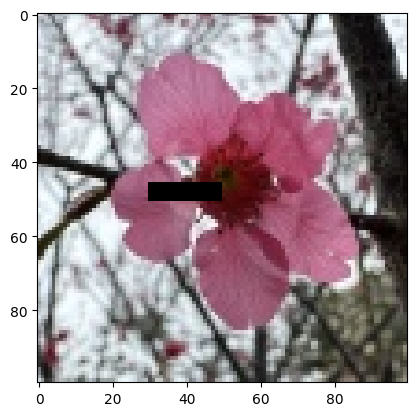

In [132]:
# For testing the add_black_patch() function
raw_img = cv.imread(dataset_path + '0002.jpg')
sample_img = cv.cvtColor(raw_img, cv.COLOR_BGR2RGB) # For plotting purposes
sample_img_w_black_patch = add_black_patch(sample_img)
plt.imshow(sample_img_w_black_patch)
# plt.axis('off')

#### 2.1.2 Shifting or Spatial Transformation

**Shifting or spatial translation** preserves the orientation of the image while shifting 
all pixels in the same direction and order <sup>[[3][imagpro_slides_5]]</sup>. This is 
going to be implemented by the `shift_image()` function which **shifts the image sideward or upwards**.

This allows the model to be capable identifying the object of focus anywhere in the 
frame.


[imagpro_slides_5]: https://dlsu.instructure.com/courses/158023/files/18754916?module_item_id=4385850

The default **max shift value** for the **x-axis** (`max_shift_x`) and 
**y-axis** (`max_shift_upwards`) would be `25`. This is to consider that the 
flower is **still visible or mostly visible** in the resulting augmented 
images. It is **not that realistic anymore or that accurate and sure if half 
of the flower is or just part of the flower is seen** since some flowers have 
similarities in some of their parts or features.

In [152]:
# Function responsible for shifting the image sideward or upwards
def shift_image(image, xy_shift_amount=None, max_shift_x=25, max_shift_upwards=25, force_shift=True):
  """
  Shifts the given image sideward or upwards using OpenCV.

  Parameters:
  - image (numpy.ndarray): Input image (RGB or grayscale).
  - shift_amount (tuple): Amount of shift in pixels (shift_x, shift_y).
  - max_shift_x (int): Maximum shift amount in pixels for sideward shift.
  - max_shift_upwards (int): Maximum shift amount in pixels for upward shift.
  - force_shift (bool): Determine if the resulting image must be force shifted if given shift amount is 0

  Returns:
  - numpy.ndarray: Shifted image.
  """
  if xy_shift_amount is None:
    # Generate random x-axis and y-axis shift amount
    rand_shift_x = random.randint(-max_shift_x, max_shift_x)
    rand_shift_y = random.randint(-max_shift_upwards, 0)
    xy_shift_amount = (rand_shift_x, rand_shift_y)
  if force_shift and xy_shift_amount[0] == 0 and xy_shift_amount[1] == 0:
    # Avoid no shift if force_shift is true
    rand_shift_x = random.randint(-max_shift_x, max_shift_x)
    rand_shift_y = random.randint(-max_shift_upwards, -1)
    xy_shift_amount = (rand_shift_x, rand_shift_y)
  # Get the shift amount for x-axis and y-axis
  shift_x, shift_y = xy_shift_amount
  # Define the transformation matrix
  M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
  # Determine the dimensions of the output image
  rows, cols = image.shape[:2]
  # Apply the shift transformation
  shifted_image = cv.warpAffine(image, M, (cols, rows))

  return shifted_image

Demonstration of the effect of the `shift_image()` can be seen below. 
Run the cell below multiple times to see that both the x-axis and y-axis 
shift amount is random and shift would only be sideway or upwards.

(-0.5, 99.5, 99.5, -0.5)

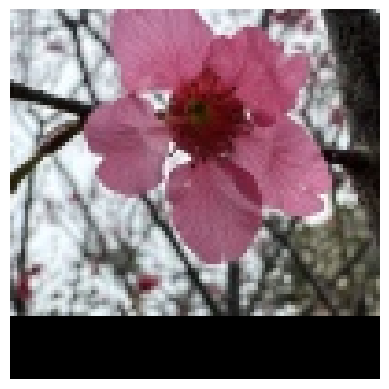

In [184]:
# For testing the shift_image() function
raw_img = cv.imread(dataset_path + '0002.jpg')
sample_img = cv.cvtColor(raw_img, cv.COLOR_BGR2RGB) # For plotting purposes
shifted_sample_img = shift_image(sample_img)
plt.imshow(shifted_sample_img)
plt.axis('off')

#### 2.1.3 Rotation

**Rotation** rotates the image by a certain angle <sup>[[3][imagpro_slides_5]]</sup>. 
This is going to be implemented by the `rotate_image()` function, which **randomly 
rotates an image at a random angle**.

This allows the model to be tolerant to the angle orientation of the object of focus.


[imagpro_slides_5]: https://dlsu.instructure.com/courses/158023/files/18754916?module_item_id=4385850

In [201]:
# Function responsible for randomly rotating an image at a random angle
def rotate_image(image, theta=None):
  if theta is None:
    theta = 0
    # Ensure that the image is rotated at an angle
    while theta == 0:
      theta = random.randint(-359, 359)
  # Determine the dimensions of the image
  rows, cols = image.shape[:2]
  # Get the center
  center = ((cols - 1) / 2.0, (rows - 1) / 2.0)
  # Calculate the rotation matrix
  M = cv.getRotationMatrix2D(center, theta, 1)
  # Apply the rotation transformation
  rotated_image = cv.warpAffine(image, M, (cols, rows))

  return rotated_image

Demonstration of the effect of the `rotate_image()` can be seen below. 
Run the cell below multiple times to see that the image is being rotated 
at a random angle every single time.

(-0.5, 99.5, 99.5, -0.5)

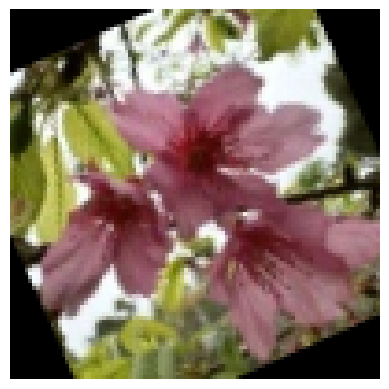

In [206]:
# For testing the rotate_image() function
raw_img = cv.imread(dataset_path + '0008.jpg')
sample_img = cv.cvtColor(raw_img, cv.COLOR_BGR2RGB) # For plotting purposes
rotated_sample_img = rotate_image(sample_img)
plt.imshow(rotated_sample_img)
plt.axis('off')

#### 2.1.4 Flipping

**Flipping** mirrors the image horizontally or vertically. This is going to 
be implemented by the `flip_image()` function, which **randomly flips an image 
either vertically or horizontally**.

This allows the model to be tolerant to the orientation of the object of focus 
assuming that a specific feature or part of the object of focus can be or is 
realistically correct with its mirrored version. 

In [207]:
# Function responsible for randomly flipping an image either vertically or horizontally
def flip_image(image, flip_horizontally=False, flip_vertically=False):
  if not (flip_vertically or flip_horizontally):
    # Generate a random flip direction
    flip_horizontally = random.choice([True, False])
    flip_vertically = not flip_horizontally
  if flip_horizontally:
    # Flip around the y-axis (horizontal)
    flipped_image = cv.flip(image, 1)
  elif flip_vertically:
    # Flip around the x-axis (vertical)
    flipped_image = cv.flip(image, 0)
  
  return flipped_image

Demonstration of the effect of the `flip_image()` can be seen below. 
Run the cell below multiple times to see that the image is being flipped 
either vertically or horizontally.

(-0.5, 99.5, 99.5, -0.5)

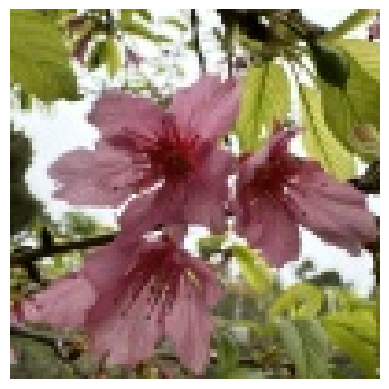

In [220]:
# For testing the rotate_image() function
raw_img = cv.imread(dataset_path + '0008.jpg')
sample_img = cv.cvtColor(raw_img, cv.COLOR_BGR2RGB) # For plotting purposes
flipped_sample_img = flip_image(sample_img)
plt.imshow(flipped_sample_img)
plt.axis('off')

### 2.2 New Augmented Dataset

A new augmented dataset is going to be produced by using the **transformation 
functions** that was created in the previous sections. The new augmented dataset 
is going to contain a total of **at least 100 images** (including the resized 
original images).

In [ ]:
# perform data augmentation
original_img_filenames = os.listdir(dataset_path)

## Conclusion and Recommendation

Given the specifications of the project it is safe to assume that the dataset 
flower detection or classification. Thus, for the sake of providing a scope 
of what data augmentation techniques that are applicable and not applicable 
the idea that the dataset is for flower detection or classification is going 
to be used.

Other than the geometric transformations implemented in the notebook, the **Color 
Jittering or Color Transformations** is also an applicable data augmentation 
technique since modifying the color properties like brightness, contrast, 
or saturation can simulate variations in lighting conditions or camera settings.

As for the not applicable data augmentation techniques for the said model, it 
includes **Scaling or Zooming**, and **Shearing**. **Scaling or Zooming** is not 
applicable because oftentimes the flowers are photographed at a consistent distance 
where it is clearly identifiable, and artificially zooming may not reflect realistic 
scenarios. **Zooming out or upscaling** would render the flower to be identical 
to a different object when it is zoomed out and is very tiny to the human eyes while 
**zooming in or downscaling** could only show a part of a flower which could also be 
identical to other objects. Additionally, flowers typically maintain their shape 
without significant deformation, so **shearing** may not be as relevant.

It is important to note that the recommended applicable and applicable data augmentation 
techniques are solely based on the assumption that the dataset is going to be used for 
flower detection or classification. Overall, choosing appropriate transformations requires 
considering the characteristics of the dataset, the nature of the task, and the expected 
variability in real-world scenarios. It's essential to balance augmentation techniques 
that enhance dataset diversity and realism without introducing unrealistic variations 
that could confuse the model.